PRE PROCESSING + UNKNOWN WORD HANDLING

In [1]:
import re
import unicodedata
from collections import Counter
import math
from typing import List, Iterable

In [2]:

BOS   = "<s>"   #beginning of the sentence
EOS   = "</s>"  #end of the senetnce
UNK   = "<UNK>" #unknown words for unseen words


In [3]:
_re_url   = re.compile(r"^(?:https?://|www\.)", re.I)      #for matching urls
_re_email = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$")      #for matching emails
_re_phone = re.compile(r"^\+?\d[\d\-\s]{5,}\d$")           #for matching phone numbers
_re_num   = re.compile(r"^\d{1,3}(?:([,._]\d{3})+|\.\d+)?$")  #for matching numbers


In [4]:
def normalize_token(tok: str) -> str:

    #normalizing the tokens by mapping them into categories
    t = unicodedata.normalize("NFC", tok).strip()
    t = t.lower()

    if _re_url.search(t):     return "<URL>"
    if _re_email.match(t):    return "<EMAIL>"
    if _re_phone.match(t):    return "<PHONE>"
    if _re_num.match(t):      return "<NUM>"

    return t


In [5]:
#reading the dataset
def read_tokenized_lines(path: str) -> List[List[str]]:
    reviews = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            reviews.append(line.split())
    return reviews

In [6]:
def normalize_reviews(reviews: List[List[str]]) -> List[List[str]]:
    return [[normalize_token(t) for t in r] for r in reviews]

# adding <s> and </s> boundaries around each sentence
def add_boundaries(reviews: List[List[str]]) -> List[List[str]]:
    return [[BOS] + r + [EOS] for r in reviews]

def build_vocab(train: List[List[str]], min_count: int = 1) -> set:       # building vocabulary from training data
    freq = Counter(word for r in train for word in r)
    vocab = {word for word, count in freq.items() if count >= min_count}                 # keeps the words above the threshold
    vocab.add(UNK)
    return vocab

def map_to_unk(reviews: List[List[str]], vocab: Iterable[str]) -> List[List[str]]:  # replacing the unseen words with <UNK>
    vcb = set(vocab)
    return [[word if word in vcb else UNK for word in r] for r in reviews]


In [7]:
# counting unigrams
def count_unigrams(reviews: List[List[str]]) -> Counter:
    return Counter(word for r in reviews for word in r)

#counting bigrams
def count_bigrams(reviews: List[List[str]]) -> Counter:
    return Counter((r[i-1], r[i]) for r in reviews for i in range(1, len(r)))


UNIGRAM AND BIGRAM PROBABILITY COMPUTATION

In [8]:
def calculate_uni_probability(unigram_counts: Counter)->dict:
  # Calculates the probability of each unigram (single word) in the corpus.
    total_unigrams = sum(unigram_counts.values())
    return {word: count / total_unigrams for word, count in unigram_counts.items()}

def calculate_bi_probability(bigram_counts: Counter, unigram_counts: Counter) -> dict:
  # Calculates the conditional probability of each bigram (pair of consecutive words) in the corpus using maximum likelihood estimation.
    return {bigram: count / unigram_counts[bigram[0]] for bigram, count in bigram_counts.items()}

In [9]:
#calculating the unigram log probability
def unigram_logprob_mle(tokens: List[str], uni_counts: Counter, N: int) -> float:
    sum = 0.0
    for word in tokens[1:]:  # skip <s>
        count = uni_counts.get(word, 0)
        if count == 0:
            return float("-inf")
        sum += math.log(count / N)
    return sum

#calculating the bigram log probability
def bigram_logprob_mle(tokens: List[str], uni_counts: Counter, bi_counts: Counter) -> float:
    sum = 0.0
    for i in range(1, len(tokens)):
        prev, word = tokens[i-1], tokens[i]
        count_prev  = uni_counts.get(prev, 0)
        count_word = bi_counts.get((prev, word), 0)
        if count_prev == 0 or count_word == 0:
            return float("-inf")
        sum += math.log(count_word / count_prev)
    return sum

SMOOTHING

Add-k Smoothing (including Laplace k = 1)

In [10]:
# Add-k Smoothing - Unigram
class AddKUnigramLM:

    def __init__(self, uni_counts: Counter, V: int, N: int, k: float = 1.0):
        # uni_counts: counts c(w) for each token w
        # V: vocabulary size, includes <UNK>, <s>, </s>
        # N: total number of tokens in training set (sum_w c(w))
        # k: smoothing constant
        self.uni, self.V, self.N, self.k = uni_counts, V, N, k

    # Add-k smoothing unigram probability calculation
    def prob(self, word: str) -> float:
        # P_k(w) = (c(w) + k) / (N + k * V)
        return (self.uni.get(word, 0) + self.k) / (self.N + self.k * self.V)

    # Log probability calculation of a token sequence for unigram model
    def logprob_seq(self, tokens: List[str]) -> float:
        sum = 0.0
        for word in tokens[1:]:  # skipping BOS token <s> so that the number of predicted tokens matches len(tokens) - 1 in perplexity computation
            # log P_k(w)
            sum += math.log(self.prob(word))
        return sum



# Add-k Smoothing - Bigram
class AddKBigramLM:

    def __init__(self, uni_counts: Counter, bi_counts: Counter, V: int, k: float = 1.0):
        # uni_counts: counts c(h) for each history token h
        # bi_counts: counts c(h, w) for each bigram (h, w)
        # V: vocabulary size, including <UNK>, <s>, </s>
        # k: smoothing constant

        self.uni, self.bi, self.V, self.k = uni_counts, bi_counts, V, k

    # Add-k smoothed bigram conditional probability
    def cond_prob(self, w: str, h: str) -> float:
        # P_k(w | h) = (c(h, w) + k) / (c(h) + k * V)
        num = self.bi.get((h, w), 0) + self.k
        # With k > 0 and V > 0, denominator is > 0 for any history h
        den = self.uni.get(h, 0) + self.k * self.V
        return num / den

    # Log probability calculation of a token sequence for bigram model
    def logprob_seq(self, tokens: List[str]) -> float:
        sum = 0.0
        # Scoring each adjacent pair (h, w) = (tokens[i-1], tokens[i]) for i >= 1
        # Because we include <s> at position 0, the number of scored pairs is len(tokens)-1
        for i in range(1, len(tokens)):
            h, w = tokens[i-1], tokens[i]
            # log P_k(w|h)
            sum += math.log(self.cond_prob(w, h))
        return sum

PERPLEXITY

In [11]:
#perplexity computation for a given model
def perplexity(logprob_func, sentences: List[List[str]]) -> float:
    total_log_prob, total_tok = 0.0, 0
    for sent in sentences:
        log_prob = logprob_func(sent)
        if log_prob == float("-inf"):        #if unseen --> infinite perplexity
            return float("inf")
        total_log_prob  += log_prob
        total_tok += max(len(sent) - 1, 1)  # ignoring <s>
    return math.exp(- total_log_prob / total_tok)


 JELINEK-MERCER SMOOTHING

In [12]:
class JMInterpolatedBigram:

    def __init__(self, uni_counts, bi_counts, N, lam: float):
        # uni_counts : Counter of c(w) for each token w (after <UNK> mapping)
        # bi_counts  : Counter of c(h, w) for each bigram (h, w)
        # N          : total number of training tokens (sum_w c(w))
        # lam (λ)    : interpolation weight ∈ [0, 1]
        # λ close to 1 trusts bigram Maximum Likelihood Estimate (MLE) more and λ close to 0 trusts unigram more

        self.uni = uni_counts
        self.bi  = bi_counts
        self.N   = N
        self.lam = lam  # 0..1

    # Unigram probability calculation
    # P(w) = c(w)/N
    def p_uni(self, word):
      # With <UNK> mapping ever token in validation set should be in V, so value is > 0 for any token in V (vocab)
        return self.uni.get(word, 0) / self.N if self.N > 0 else 0.0

   # Bigram Maximum Likelihood Estimate probability calculation
   # P(w|h) = c(h,w) / c(h)
    def p_bi_mle(self, w, h):
        ch  = self.uni.get(h, 0)
        chw = self.bi.get((h, w), 0)
        # Maybe 0 if the bigram (h,w) never occurred in training set
        return 0.0 if ch == 0 else chw / ch


   # Jelinek–Mercer interpolation
   # P_JM(w|h) = λ * P_MLE(w|h) + (1-λ) * P_uni(w)
    def cond_prob(self, w, h):
        # P_JM = λ P_MLE(w|h) + (1-λ) P_uni(w)
        return self.lam * self.p_bi_mle(w, h) + (1 - self.lam) * self.p_uni(w)

    # Log probability calculation of a token sequence for Jelinek-Mercer model
    def logprob_seq(self, tokens):
        sum = 0.0
        for i in range(1, len(tokens)):
          # Scoring adjacent pairs (h=tokens[i-1], w=tokens[i]) for i >= 1 with <s> at index 0, this aligns with perplexity denominator of len(tokens)-1
            h, w = tokens[i-1], tokens[i]
            p = self.cond_prob(w, h)
            if p == 0.0:
                return float("-inf")
            sum += math.log(p)
        return sum



In [16]:
if __name__ == "__main__":
    # Setting train and test data paths
    TRAIN_PATH = "train.txt"
    VAL_PATH   = "val.txt"

    # Reading raw lines from the train and validation text files (each line is one review)
    train_data = read_tokenized_lines(TRAIN_PATH)
    val_data   = read_tokenized_lines(VAL_PATH)

    # Normalize
    train_data = normalize_reviews(train_data)
    val_data   = normalize_reviews(val_data)

    #  Build vocab from TRAIN only, add <UNK>, map UNK on both
    MIN_COUNT = 2   # adjust if you want to collapse rare words (e.g., 2)
    vocab = build_vocab(train_data, min_count=MIN_COUNT)
    train_data = map_to_unk(train_data, vocab)
    val_data   = map_to_unk(val_data, vocab)

    # Add boundaries to both (prevents cross-review bigrams)
    train_data = add_boundaries(train_data)
    val_data   = add_boundaries(val_data)

    # Count ONCE on mapped TRAIN
    uni_counts = count_unigrams(train_data)
    bi_counts  = count_bigrams(train_data)
    N          = sum(uni_counts.values())
    V          = len(vocab)

    # Calculating unigram and bigram probability
    unigram_prob = calculate_uni_probability(uni_counts)
    bigram_prob = calculate_bi_probability(bi_counts, uni_counts)
    print("Unigram Probability: ", unigram_prob)
    print("Bigram Probability: ", bigram_prob)

    # Evaluate MLE(maximum likelihood estimation) perplexities
    ppx_uni_mle = perplexity(lambda s: unigram_logprob_mle(s, uni_counts, N), val_data)
    ppx_bi_mle  = perplexity(lambda s: bigram_logprob_mle(s, uni_counts, bi_counts), val_data)

    print("\n=====Perplexity (unsmoothed) on training set===== ")
    print("Unigram MLE :", perplexity(lambda s: unigram_logprob_mle(s, uni_counts, N), train_data))
    print("Bigram  MLE :", perplexity(lambda s: bigram_logprob_mle(s, uni_counts, bi_counts), train_data))

    print("\n=====Perplexity (unsmoothed) on validation set===== ")
    print("Unigram MLE :", ppx_uni_mle)
    print("Bigram  MLE :", ppx_bi_mle)

    # 7) Add-k smoothing (at least two k values)
    uni_add1  = AddKUnigramLM(uni_counts, V, N, k=1.0)            # Laplace
    bi_add1   = AddKBigramLM(uni_counts, bi_counts, V, k=1.0)     #Laplace
    uni_add01 = AddKUnigramLM(uni_counts, V, N, k=0.01)           #Add-k
    bi_add01  = AddKBigramLM(uni_counts, bi_counts, V, k=0.01)    #Add-k

    best_lam = 0.7
    jm_bigram = JMInterpolatedBigram(uni_counts, bi_counts, N, lam=best_lam)    #jelinek mercer

    print("\n=====Perplexity after smoothing on training set=====")
    print("Unigram - Laplace  :", perplexity(uni_add1.logprob_seq,  train_data))
    print("Unigram - Add-k (k=0.01) :", perplexity(uni_add01.logprob_seq, train_data))
    print("\nBigram - Laplace :", perplexity(bi_add1.logprob_seq,   train_data))
    print("Bigram - Add-k (k=0.01) :", perplexity(bi_add01.logprob_seq,  train_data))

    print("\n=====Perplexity after smoothing on development/validation set=====")
    print("Unigram - Laplace  :", perplexity(uni_add1.logprob_seq,  val_data))
    print("Unigram - Add-k (k=0.01) :", perplexity(uni_add01.logprob_seq, val_data))
    print("\nBigram - Laplace  :", perplexity(bi_add1.logprob_seq,   val_data))
    print("Bigram - Add-k (k=0.01) :", perplexity(bi_add01.logprob_seq,  val_data))

    print("\n=====Perplexity with JM interpolation (λ=0.7)=====")
    print("JM Bigram (train):", perplexity(jm_bigram.logprob_seq, train_data))
    print("JM Bigram (val):  ", perplexity(jm_bigram.logprob_seq, val_data))


Unigram Probability:  {'<s>': 0.0056444856021519605, 'i': 0.0188076024165454, 'booked': 0.0009480971909864621, 'two': 0.0014111214005379901, 'rooms': 0.0022159015742823124, 'four': 0.00022048771883406094, 'months': 8.819508753362438e-05, 'in': 0.013879701900604136, 'advance': 7.717070159192133e-05, 'at': 0.00821316752656877, 'the': 0.05834105040349252, 'talbott': 0.0003086828063676853, '.': 0.0517264188384707, 'we': 0.012303214710940601, 'were': 0.006372095074304362, 'placed': 8.819508753362438e-05, 'on': 0.00705560700268995, 'top': 0.0004409754376681219, 'floor': 0.0015103408740133174, 'next': 0.001179609295762226, 'to': 0.023040966618159367, 'elevators': 0.00035278035013449753, ',': 0.032510914142082285, 'which': 0.0019402919257397362, 'are': 0.0034175596419279445, 'used': 0.00038585350795960664, 'all': 0.003064779291793447, 'night': 0.0021938528023989065, 'long': 0.00042995105172641886, 'when': 0.0030096573620849317, 'speaking': 3.307315782510914e-05, 'front': 0.0013780482427128808,

Comparision Analysis of different λ values on training and validation sets to find best values for jelinek mercer


In [18]:
def eval_jm_train(uni_counts, bi_counts, N, train,lams=(0.9, 0.8, 0.7, 0.6, 0.5)): # Evaluating these λ values on training set
    rows = []
    for lam in lams:
        # Jelinek-Mercer model with a specific λ using the same counts and total tokens N
        jm = JMInterpolatedBigram(uni_counts, bi_counts, N, lam)
        # Perplexity calculation on train set for comparision
        ppx = perplexity(jm.logprob_seq, train)
        rows.append((lam, ppx))
    print("\nλ   PP(bigram JM (train))")
    for lam, ppx in rows:
        print(f"{lam:.2f}  {ppx}")
    return rows

_ = eval_jm_train(uni_counts, bi_counts, N, train_data,)

def eval_jm_val(uni_counts, bi_counts, N, val, lams=(0.9, 0.8, 0.7, 0.6, 0.5)): # Evaluating out these λ values on validation set
    rows = []
    for lam in lams:
        # Jelinek-Mercer model with a specific λ using the same counts and total tokens N
        jm = JMInterpolatedBigram(uni_counts, bi_counts, N, lam)
        # Perplexity calculation on validation set for comparision
        ppx = perplexity(jm.logprob_seq, val)
        rows.append((lam, ppx))
    print("\nλ   PP(bigram JM (val))")
    for lam, ppx in rows:
        print(f"{lam:.2f}  {ppx}")
    return rows

_ = eval_jm_val(uni_counts, bi_counts, N, val_data,)



λ   PP(bigram JM (train))
0.90  35.40295224642169
0.80  38.3911500725293
0.70  42.07818449806346
0.60  46.719146821841484
0.50  52.738367048641805

λ   PP(bigram JM (val))
0.90  116.57338110320799
0.80  106.34900313790982
0.70  103.94548227140083
0.60  105.12294433777056
0.50  109.01598004332126


Comparision Analysis of different k values on validation set to find best values of k for add-k


In [19]:

# Evaluating unigram Add-k smoothing over a list of k values to choose best value for k
def eval_addk_grid_uni(ks=(0.2, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02,0.01,0.005)):
    rows = []
    for k in ks:
        # Add-k unigram model with specific k with the same counts, vocal size V, total tokens N
        uni_k = AddKUnigramLM(uni_counts, V, N, k=k)
        # Perplexity calculation on validation set for comparision
        ppx  = perplexity(uni_k.logprob_seq, val_data)
        rows.append((k, ppx))
    print("\nk    PP(unigram Add-k)")
    for k, ppx in rows:
        print(f"{k:<4} {ppx}")
    return rows

_ = eval_addk_grid_uni()

# Evaluating bigram Add-k smoothing over a list of k values to choose best value for k
def eval_addk_grid_bi(k_values=(0.2, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02,0.01,0.005)):
    rows = []
    for k in k_values:
       # Add-k bigram model with specific k with the same counts, vocal size V, total tokens N
        bi_k = AddKBigramLM(uni_counts, bi_counts, V, k=k)
        # Perplexity calculation on validation set for comparision
        ppx  = perplexity(bi_k.logprob_seq, val_data)
        rows.append((k, ppx))
    print("\nk    PP(bigram Add-k)")
    for k, ppx in rows:
        print(f"{k:<4} {ppx}")
    return rows

_ = eval_addk_grid_bi()



k    PP(unigram Add-k)
0.2  288.94208441295365
0.15 288.8523413961383
0.12 288.8001925187366
0.1  288.76615292166827
0.08 288.7327055800857
0.05 288.6836667183832
0.02 288.6360171272105
0.01 288.6204488007239
0.005 288.61272443459006

k    PP(bigram Add-k)
0.2  218.53837408784497
0.15 200.05224342080865
0.12 188.02101020691862
0.1  179.50151049295422
0.08 170.50087497176045
0.05 155.9391706189771
0.02 140.83018594021183
0.01 138.24805660502736
0.005 141.80539810373327



λ   PP(bigram JM (train))
0.90  35.40295224642169
0.80  38.3911500725293
0.70  42.07818449806346
0.60  46.719146821841484
0.50  52.738367048641805

λ   PP(bigram JM (val))
0.90  116.57338110320799
0.80  106.34900313790982
0.70  103.94548227140083
0.60  105.12294433777056
0.50  109.01598004332126


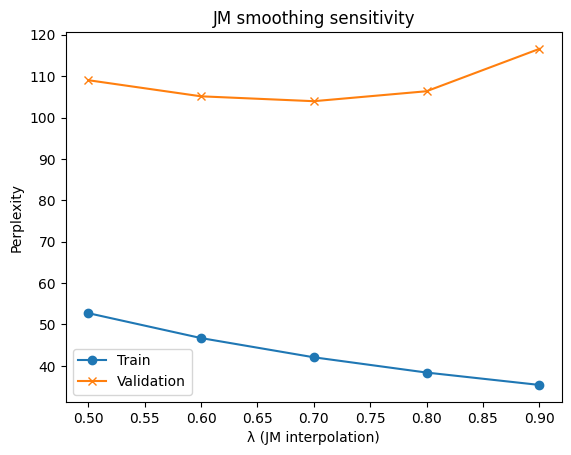

In [ ]:
#here we are evaluating and plotting the jelinek mercer(bigram) smoothing on the train and validation sets
import matplotlib.pyplot as plt

train_rows = eval_jm_train(uni_counts, bi_counts, N, train)
val_rows   = eval_jm_val(uni_counts, bi_counts, N, val)

lams, train_ppx = zip(*train_rows)      #we are using the lambda values we calculated perviously
lams, val_ppx = zip(*val_rows)

plt.plot(lams, train_ppx, marker='o', label="Train")
plt.plot(lams, val_ppx, marker='x', label="Validation")
plt.xlabel("λ (JM interpolation)")
plt.ylabel("Perplexity")
plt.title("JM smoothing sensitivity")
plt.legend()
plt.show()



k    PP(unigram Add-k)
0.2  288.94208441295365
0.15 288.8523413961383
0.12 288.8001925187366
0.1  288.76615292166827
0.08 288.7327055800857
0.05 288.6836667183832
0.02 288.6360171272105
0.01 288.6204488007239
0.005 288.61272443459006

k    PP(bigram Add-k)
0.2  218.53837408784497
0.15 200.05224342080865
0.12 188.02101020691862
0.1  179.50151049295422
0.08 170.50087497176045
0.05 155.9391706189771
0.02 140.83018594021183
0.01 138.24805660502736
0.005 141.80539810373327


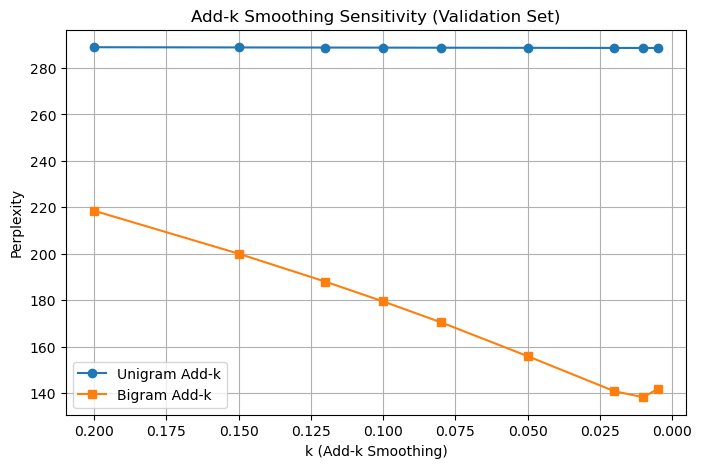

In [20]:
#here we are evaluating and plotting the add-k smoothing on the validation sets for unigrams and bigrams
import matplotlib.pyplot as plt

uni_rows = eval_addk_grid_uni()  # returns list of (k, PP) for unigram which have been computed previously
bi_rows  = eval_addk_grid_bi()   # returns list of (k, PP) for bigram which have been computed previously

k_uni, ppx_uni = zip(*uni_rows)  # extracting the k values and perplexities
k_bi,  ppx_bi  = zip(*bi_rows)

plt.figure(figsize=(8,5))
plt.plot(k_uni, ppx_uni, marker='o', label="Unigram Add-k")
plt.plot(k_bi, ppx_bi, marker='s', label="Bigram Add-k")
plt.xlabel("k (Add-k Smoothing)")
plt.ylabel("Perplexity")
plt.title("Add-k Smoothing Sensitivity (Validation Set)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.show()
